In [ ]:
1

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import h5py
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from dotmap import DotMap

In [5]:
PROJECT_PATH = '../'
DATA_DIR = "/home/swei20/LV/data/"
PCA_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/pca/spectra.h5'
NORM_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux.h5"
sys.path.insert(0, PROJECT_PATH)

In [6]:
GRID_PATH="/scratch/ceph/dobos/data/pfsspec/import/stellar/grid/bosz_5000/spectra.h5"

In [1]:
1

1

# 

In [8]:
with h5py.File(NORM_PATH, 'r') as f:
    para = f['para'][()]
    
    wave0 = f['wave'][()]

In [ ]:
with h5py.File(NORM_PATH, 'r') as f:
    flux = f['flux'][()]

In [8]:
wave0

array([ 3000.2639,  3000.564 ,  3000.8643, ..., 13996.3662, 13997.7656,
       13999.166 ])

In [9]:
strt = np.digitize([3800,12600], wave0)

In [ ]:
with h5py.File(NORM_PATH, 'r') as f:
    flux0 = f['flux'][..., strt[0]:strt[1]]
    mask = f['flux_idx'][()]
    wave = f['wave'][strt[0]:strt[1]]

In [ ]:
wave

In [ ]:
def applyLSF(spec):
    #---------------------------------------------------------
    # apply a line spread function with 1.3 pixels at R=5000
    # this is still using the log(lambda) binning in hirez
    #---------------------------------------------------------
    sigma = 1.3 * 20
    fspec = sp.ndimage.gaussian_filter1d(spec,sigma)
    return fspec

def resampleSpec(spec, step):
    c = np.cumsum(spec)
    b = list(range(1,spec.shape[0],step))
    db = np.diff(c[b])
    dd = (db/step)
    return dd

def resampleWave(wave,step):
    w = np.cumsum(np.log(wave))
    b = list(range(1,wave.shape[0],step))
    db = np.diff(w[b])
    dd = (db/step)
    return np.exp(dd)

In [ ]:
nSpec = flux.shape[0]

In [ ]:
for i in range(flux.shape[0])

In [22]:
# DATA_PATH = "/home/swei20/LV/data/ori_flux.h5"
DATA_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux_R3500.h5"

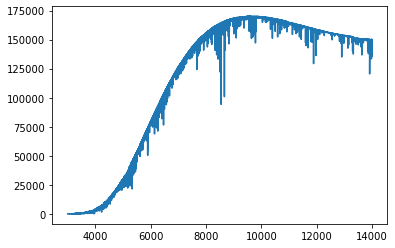

In [20]:
plt.plot(wave, flux[0])

In [18]:
wave.shape

(15404,)

In [23]:
with h5py.File(DATA_PATH,"w") as f:
    f.create_dataset("flux", data = flux, shape = flux.shape)
    f.create_dataset("wave", data = wave, shape = wave.shape)
    f.create_dataset("para", data = para0, shape = para0.shape)


In [ ]:
flux = flux0[maska
            ]

In [16]:
para0

array([[-2.5e+00,  3.5e+03,  0.0e+00, -5.0e-01, -2.5e-01],
       [-2.5e+00,  3.5e+03,  0.0e+00, -5.0e-01,  0.0e+00],
       [-2.5e+00,  3.5e+03,  0.0e+00, -5.0e-01,  2.5e-01],
       ...,
       [ 7.5e-01,  3.0e+04,  5.0e+00,  5.0e-01,  0.0e+00],
       [ 7.5e-01,  3.0e+04,  5.0e+00,  5.0e-01,  2.5e-01],
       [ 7.5e-01,  3.0e+04,  5.0e+00,  5.0e-01,  5.0e-01]])

In [24]:
wave.shape

(15404,)

In [8]:
strt = np.digitize([3000,14000], wave0)

In [9]:
strt

array([ 4055, 19459])

In [5]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

### Load data

In [15]:
with h5py.File(NORM_PATH, 'r') as f:
#     flux0 = f['flux'][()]
    para0 = f['para'][()]
#     wave0 = f['wave'][()]

In [6]:
flux0.shape, wave0.shape

((116614, 3850), (3850,))

In [7]:
from lv.base.dataloader import DataLoader

In [113]:
ds = DataLoader()

### Testing Cupy speed

In [114]:
ds.prepare_data(flux0, wave0, "H", "H", fix_CO=0, para=para0, center=0)

center 0 HH0 flux: 80442, wave: 1214


In [57]:
Mc= cp.asarray(ds.flux, dtype=cp.float32)

In [15]:
%timeit cp.linalg.svd(Mc, full_matrices=False)

396 ms ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit np.linalg.svd(M, full_matrices=False)

7.48 s ± 284 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit ds._svd(M, rank=100, tol=1e-2)

5.96 s ± 820 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Using cupy for pcp since it's much faster

In [40]:
from lv.pcp.pcpc import pcp_cupy

In [41]:
L, S, (u,s,v) = pcp_cupy(Mc, delta=1e-5, mu=11, lam = 0.0035, maxiter=500)

11 0.0035 320797.8


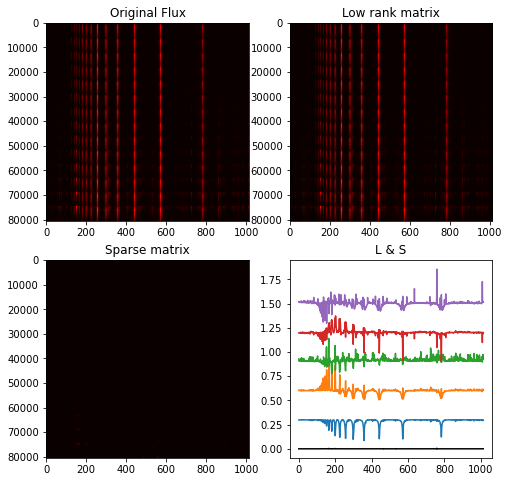

In [50]:
ds.plot_pcp(cp.asnumpy(Mc), L,S, u,s,v)

### generating mask

In [144]:
from lv.base.mask import get_mask, plot_SL

In [198]:
Mc= cp.asarray(ds.flux, dtype=cp.float32)

In [199]:
Mc.shape

(80442, 1214)

In [200]:
u,w,v = cp.linalg.svd(Mc, full_matrices=0)

In [201]:
vn = cp.asnumpy(v)

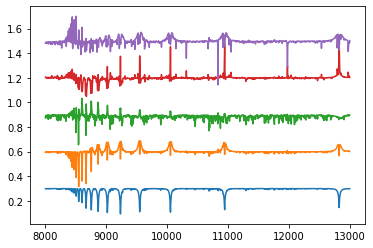

In [202]:
for i in range(min(len(v),5)):
    plt.plot(ds.wave, vn[i] + 0.3*(1 + i))
#     plt.plot(self.wave, np.mean(np.abs(S), axis=0), c="k")

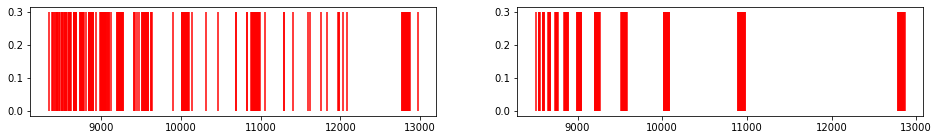

In [203]:
mask = get_mask(v, ds, k=5,q=0.6,step=2)

### plot S

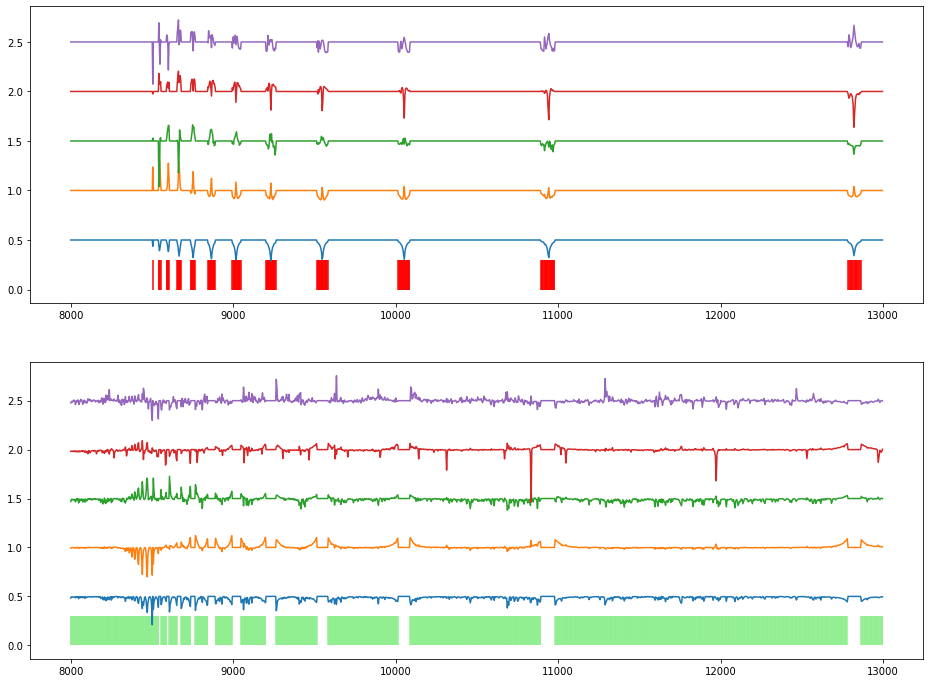

In [161]:
plot_SL(ds, mask, Mc)


### q = 0.6

In [204]:
# mask = get_mask(v, ds, k=5,q=0.8,step=2)

In [185]:
S0 = cp.zeros(Mc.shape)
S0[:,mask] = Mc[:,mask]
# _,wS,vS = cp.linalg.svd(S, full_matrices=0)

In [205]:
L0 = cp.zeros(Mc.shape)
L0[:,~mask] = Mc[:,~mask]

In [208]:
L0 = cp.asarray(L0, dtype="float16")

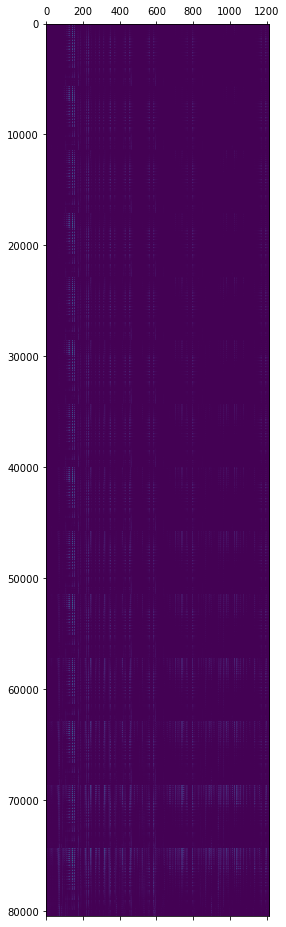

In [206]:
plt.matshow(cp.asnumpy(L0), aspect="auto")

In [211]:
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()

In [212]:
L1, S1, (u,s,v1) = pcp_cupy(L0, delta=1e-5, maxiter=50)


40.74122 0.003525807279719099 25924.32


In [250]:
NS_np = cp.asarray(S1) 

In [251]:
_,_,vNS=cp.linalg.svd(NS_np, full_matrices=0)

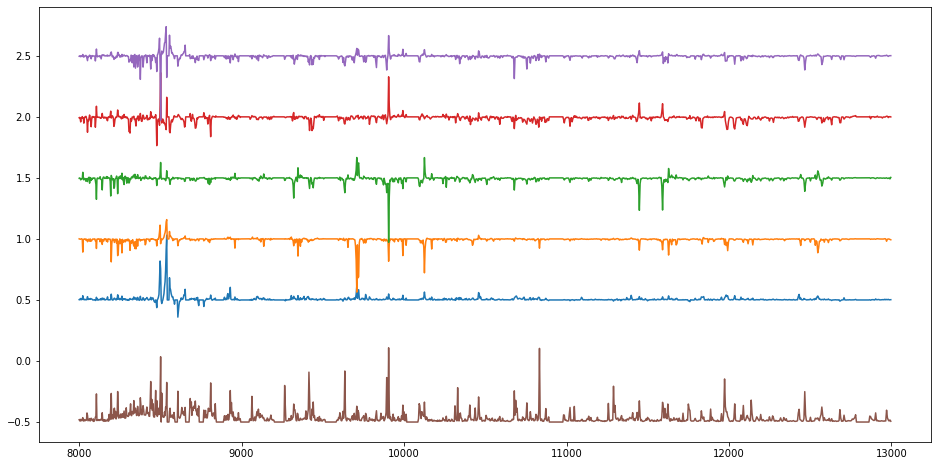

In [252]:
f, ax = plt.subplots(figsize=(16,8))
ds.plot_eigv(cp.asnumpy(vNS),gap=0.5,ax=ax)
ax.plot(ds.wave, np.sum(np.abs(S1)/100.0, axis=0)-0.5)

###### f, ax = plt.subplots(figsize=(16,8))
ds.plot_eigv(cp.asnumpy(v1),gap=0.5,ax=ax)
ax.plot(ds.wave, np.sum(np.abs(S1)/100.0, axis=0)-0.5)

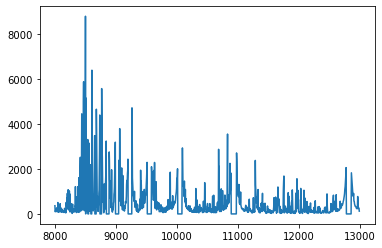

In [236]:
plt.plot(ds.wave, np.sum(np.abs(L1), axis=0))

In [239]:
v11 = cp.asnumpy(v1)

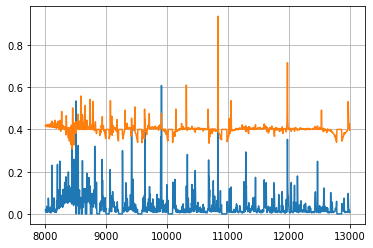

In [245]:
plt.plot(ds.wave, np.sum(np.abs(S1)/100.0, axis=0))
plt.plot(ds.wave, v11[3] + 0.4)
plt.grid(1)

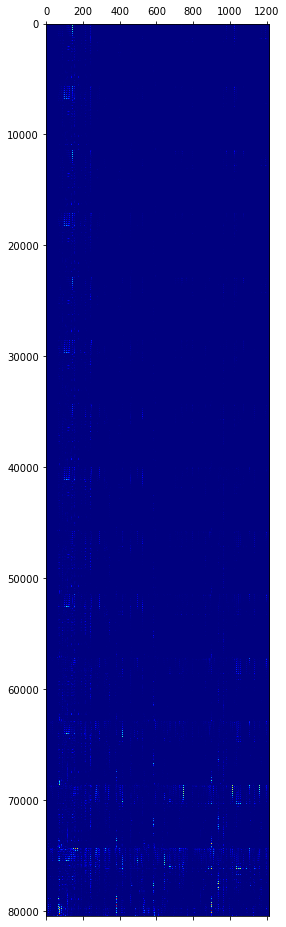

In [233]:
plt.matshow(np.abs(S1), vmax=0.02, aspect="auto" , cmap="jet")

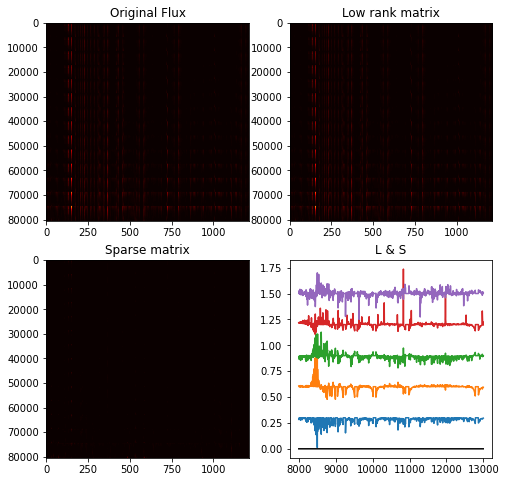

In [224]:
ds.plot_pcp(L1, L1,S1, u,s,v1)

In [187]:
ss = cp.asnumpy(S)

In [181]:
_,_,vL = cp.linalg.svd(cp.asarray(L, dtype=cp.float32), full_matrices=0)

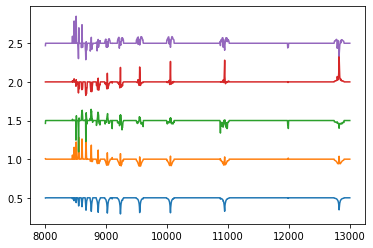

In [184]:

ds.plot_eigv(cp.asnumpy(vL),gap=0.5)

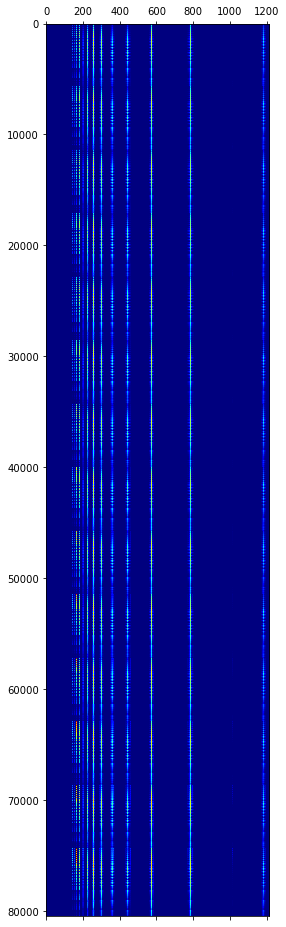

In [179]:
plt.matshow(L, cmap="jet", vmin=0.0, vmax=0.8, aspect="auto")

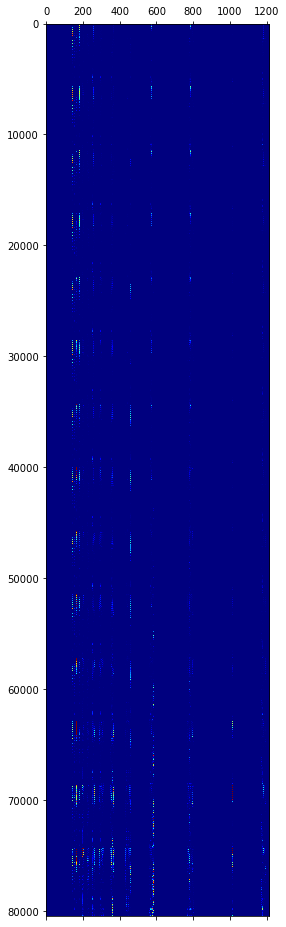

In [189]:
plt.matshow(ss*10, cmap="jet", vmin=0.0, vmax=0.2, aspect="auto")

In [191]:
sc = cp.asarray(ss, dtype=cp.float32)

In [192]:
sc

array([[-0.0000000e+00,  0.0000000e+00, -0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-8.1065082e-05,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.2513758e-04, -0.0000000e+00, -0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [193]:
_,_,vS = cp.linalg.svd(sc, full_matrices=0)

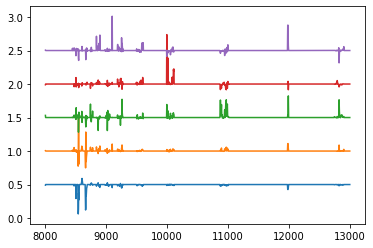

In [194]:
ds.plot_eigv(cp.asnumpy(vS),gap=0.5)

In [196]:
vS.shape

(1214, 1214)

In [195]:
ds.flux.shape

(80442, 1214)

In [ ]:
M

In [ ]:
ds.flux.dot()

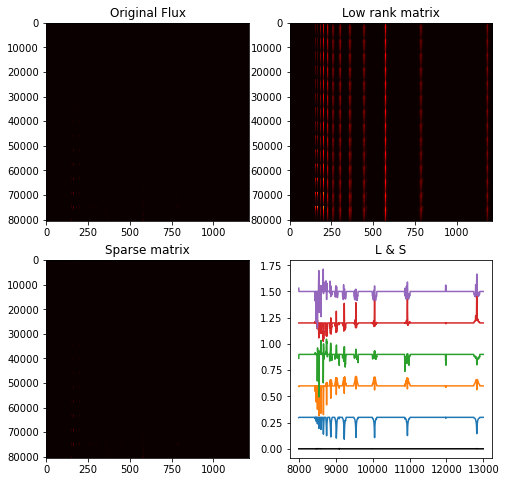

In [170]:
ds.plot_pcp(cp.asnumpy(S), L,S, u,s,v)

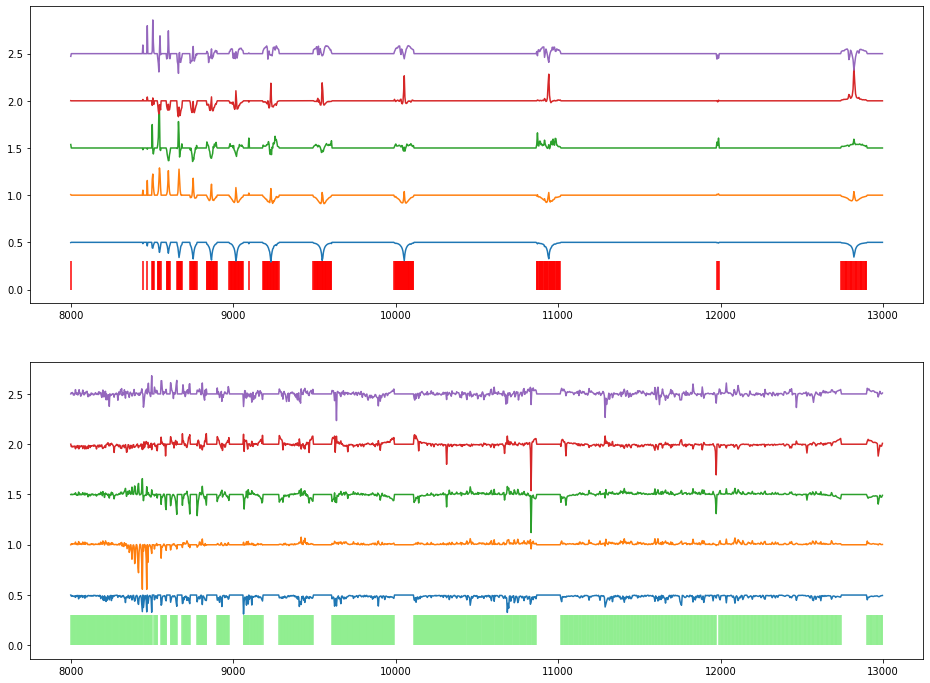

In [165]:
plot_SL(ds, mask, Mc)